In [1]:
import os
import pickle
import pandas as pd
import mudata as mu
from pycisTopic.cistopic_class import create_cistopic_object
from pycisTopic.lda_models import run_cgs_models, evaluate_models
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.diff_features import impute_accessibility, normalize_scores, find_highly_variable_features, find_diff_features
from pycisTopic.utils import region_names_to_coordinates

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 11:27:45,267	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [19]:
path_data = "/cellar/users/aklie/data/datasets/neurips2021_small/annotation/2023_12_05/mdata.h5mu"
cluster_key = "celltype"
organism = "human"
n_topics = '2;4;8;16'
n_iter = 150
alpha = 50
alpha_by_topic = True
eta = 0.1
eta_by_topic = False
n_cpu = 4
ntop = 3000
scale_factor_impute = 1000000
scale_factor_normalize = 10000
temp_dir = "/cellar/users/aklie/tmp"
random_state = 1234
path_out = "/cellar/users/aklie/data/datasets/neurips2021_small/analysis/scenic+/2024_05_08"

In [25]:
# Read atac adata
adata = mu.read(path_data)
del adata.mod['rna']
obs = adata.obs.copy()
adata = adata.mod['atac'].copy()
adata.obs = obs
adata

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 123 × 8192
    obs: 'atac:pseudotime_order', 'rna:pseudotime_order', 'celltype', 'batch', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    obsm: 'X_lsi', 'X_umap'
    layers: 'counts'

In [26]:
# 
adata.obs[cluster_key] = adata.obs[cluster_key].str.replace("/", "_").copy()

In [27]:
# 
if organism == 'human':
    path_blacklist = '/cellar/users/aklie/opt/gene_program_evaluation/src/inference/grn_models/scenic+/resources/blacklists/human.bed'
elif organism == 'mouse':
    path_blacklist = 'resources/blacklists/mouse.bed'

In [28]:
# Make first occurences of "-" ":" in var_names if multiple exist
if sum(adata.var.index.str.contains("-")) > 0:
    adata.var.index = adata.var.index.str.replace("-", ":", 1)

In [29]:
# Create cisTopic object
cistopic_obj = create_cistopic_object(
    fragment_matrix=adata.to_df().T,
    cell_names=adata.obs.index.values,
    region_names=adata.var.index.values,
    path_to_blacklist=path_blacklist,
    split_pattern="_",
    tag_cells=False,
)

2024-05-08 11:31:20,100 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-05-08 11:31:20,116 cisTopic     INFO     Removing blacklisted regions
2024-05-08 11:31:20,264 cisTopic     INFO     Creating CistopicObject
2024-05-08 11:31:20,283 cisTopic     INFO     Done!


In [30]:
# Add cell metadata
cistopic_obj.add_cell_data(obs)

In [31]:
# Process n_topics
n_topics = n_topics.split(';')
n_topics = [int(n) for n in n_topics]

In [32]:
# Compute topic models
models = run_cgs_models(
    cistopic_obj,
    n_topics=n_topics,
    n_cpu=n_cpu,
    n_iter=n_iter,
    random_state=random_state,
    alpha=alpha,
    alpha_by_topic=alpha_by_topic,
    eta=eta,
    eta_by_topic=eta_by_topic,
    save_path=None,
    _temp_dir=temp_dir
)

2024-05-08 11:31:24,683	INFO worker.py:1724 -- Started a local Ray instance.


(run_cgs_model pid=3153991) 2024-05-08 11:31:29,647 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=3153989) 2024-05-08 11:31:33,568 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=3153988) 2024-05-08 11:31:29,647 cisTopic     INFO     Running model with 8 topics [repeated 3x across cluster]
(run_cgs_model pid=3153988) 2024-05-08 11:31:35,583 cisTopic     INFO     Model with 8 topics done! [repeated 2x across cluster]


In [33]:
# Save models object
with open(os.path.join(path_out, "models.pkl"), 'wb') as f:
    pickle.dump(models, f)

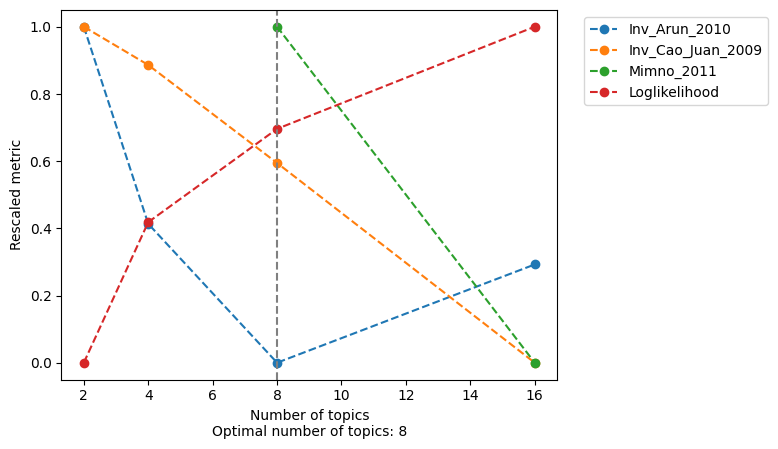

In [34]:
# Add model to cistopic object
model = evaluate_models(
    models,
    select_model=None,
    return_model=True,
    metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
    plot_metrics=False
)
cistopic_obj.add_LDA_model(model)

In [35]:
# Save the cistopic object
pickle.dump(cistopic_obj, open(os.path.join(path_out, "cistopic_obj.pkl"), 'wb'))

In [36]:
# Binarize topics using otsu and top
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, 
    method='otsu',
    plot=False
)
region_bin_topics_top = binarize_topics(
    cistopic_obj, 
    method='ntop', 
    ntop=ntop,
    plot=False
)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
# Impute accessibility by matrix multiplication
imputed_acc_obj = impute_accessibility(
    cistopic_obj,  # cisTopic object
    selected_cells=None,  # certain cells to use for imputation
    selected_regions=None,  # certain regions to use for imputation
    scale_factor=scale_factor_impute,  # A number to multiply the imputed values for.
    project=cistopic_obj.project + "impute"  # A string to add to the name of the imputed object.
)

2024-05-08 11:31:54,531 cisTopic     INFO     Imputing region accessibility
2024-05-08 11:31:54,532 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-05-08 11:31:54,552 cisTopic     INFO     Done!


In [38]:
# Normalize accessibility scores
normalized_imputed_acc_obj = normalize_scores(
    imputed_acc_obj, 
    scale_factor=scale_factor_normalize  # Scale factor for cell-level normalization
)

2024-05-08 11:31:55,173 cisTopic     INFO     Normalizing imputed data
2024-05-08 11:31:55,196 cisTopic     INFO     Done!


In [39]:
# Find highly variable regions
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj, 
    plot=False
)

2024-05-08 11:31:55,630 cisTopic     INFO     Calculating mean
2024-05-08 11:31:55,633 cisTopic     INFO     Calculating variance
2024-05-08 11:31:55,752 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

In [40]:
# Find differentially accessible regions
markers = find_diff_features(
    cistopic_obj, 
    imputed_acc_obj, 
    variable=cluster_key,
    var_features=variable_regions, 
    split_pattern="_"
)

2024-05-08 11:31:56,141 cisTopic     INFO     Subsetting data for Erythroblast (26 of 123)
2024-05-08 11:32:02,053 cisTopic     INFO     Computing p-value for Erythroblast
2024-05-08 11:32:05,050 cisTopic     INFO     Computing log2FC for Erythroblast
2024-05-08 11:32:07,327 cisTopic     INFO     Erythroblast done!
2024-05-08 11:32:07,329 cisTopic     INFO     Subsetting data for HSC (26 of 123)
2024-05-08 11:32:07,332 cisTopic     INFO     Computing p-value for HSC
2024-05-08 11:32:10,335 cisTopic     INFO     Computing log2FC for HSC
2024-05-08 11:32:10,343 cisTopic     INFO     HSC done!
2024-05-08 11:32:10,343 cisTopic     INFO     Subsetting data for MK_E prog (24 of 123)
2024-05-08 11:32:10,345 cisTopic     INFO     Computing p-value for MK_E prog
2024-05-08 11:32:13,338 cisTopic     INFO     Computing log2FC for MK_E prog
2024-05-08 11:32:13,350 cisTopic     INFO     MK_E prog done!
2024-05-08 11:32:13,351 cisTopic     INFO     Subsetting data for Normoblast (21 of 123)
2024-05-

In [41]:
os.makedirs(os.path.join(path_out, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(path_out, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(path_out, "region_sets", "Topics_top"), exist_ok = True)
os.makedirs(os.path.join(path_out, "region_sets", "DARs"), exist_ok = True)

In [42]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(path_out, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [43]:
for topic in region_bin_topics_top:
    region_names_to_coordinates(
        region_bin_topics_top[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(path_out, "region_sets", "Topics_top", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [44]:
for cluster in markers:
    region_names_to_coordinates(
        markers[cluster].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(path_out, "region_sets", "DARs", f"{cluster}.bed"),
        sep = "\t",
        header = False, index = False
    )

# DONE!

---